# Game Music dataset: genre classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix

In [3]:
df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df_genres.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df_genres.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 34510 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


# Problem statement

By joining the game music dataframe with the features dataset produced by JSymbolic, the final dataset to be used for the classification task is obtained.

This dataset provides 156 musical feature for each valid midi. 

In [4]:
df_pred = df_genres[['genre']].join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

,file_name,genre,Prevalence_of_Most_Common_Pitch,Prevalence_of_Most_Common_Pitch_Class,Relative_Prevalence_of_Top_Pitches,Relative_Prevalence_of_Top_Pitch_Classes,Interval_Between_Most_Prevalent_Pitches,Interval_Between_Most_Prevalent_Pitch_Classes,Number_of_Common_Pitches,Pitch_Variety,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,0004cc74bde3bc82f44afb5f566187c3dbcea9b2.mid,Platform,0.1593,0.2242,0.7222,0.7500,5.0,5.0,2.0,28.0,...,0.0000,0.0,0.0000,0.00000,0.0,0.0,63.0,17.65,6.3240,13.7800
1,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Action,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
2,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Adventure,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
3,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Sports,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
4,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Strategy,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128


To simplify this first analysis, only the categories which are the most represented in the dataset will be considered. The threshold for being worth considering is fixed at 2000 MIDIs. 

In [5]:
df_counts = df_genres.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_counts

,genre,counts
0,Action,8524
12,Role-Playing,6617
9,Platform,5040
1,Adventure,4802
14,Shooter,2248
3,Fighting,1848
10,Puzzle,1483
15,Sports,1122
17,Strategy,1098
11,Racing,813


In [6]:
df_pred_sel = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > 2000]['genre'])]
print("For this first analysis, 5 genres entailing " + str(df_pred_sel.shape[0]) + " MIDIs will be considered.")
print('The genres are: %s'%", ".join(np.unique(df_pred_sel['genre'])))

For this first analysis, 5 genres entailing 27010 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing, Shooter


The dataset is divided into features and labels - X and y respectively - for the purpose of the classification task. The labels Y are mapped to integers to comply with the requirements of certain Machine Learning models such as linear regression.

In [7]:
X = df_pred_sel.iloc[:, 2:]
y, labels = pd.factorize(df_pred_sel['genre'])

The dataset is split into training and testing sets with a 8-2 ratio, which seems very reasonable considering the size of the dataset.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)
print(str(X_train.shape[0]) + " MIDIs are used for training, " + str(X_test.shape[0]) + " are used for testing.")
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

21608 MIDIs are used for training, 5402 are used for testing.


Lastly, let's take a look at the repartition of the genres in the whole dataset, the train and the test sets.

In [9]:
val, counts_dataset = np.unique(y, return_counts=True)
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame([counts_dataset/counts_dataset.sum(), counts_train/counts_train.sum(), counts_test/counts_test.sum()],\
             columns=[labels[i] for i in val], index=['Full data', 'Train data', 'Test data'])

,Platform,Action,Adventure,Role-Playing,Shooter
Full data,0.184783,0.312514,0.177453,0.242355,0.082895
Train data,0.183913,0.313032,0.176046,0.244400,0.082608
Test data,0.188264,0.310441,0.183080,0.234173,0.084043


It can be noted that the three datasets share a similar proportion in the ratio of genres. However, these proportion are unbalanced and far from the ideal situation where each genre has equal weight in the dataset. This unbalancedness is a form of bias.

# Models Evaluation

In this section various Machine Learning classification models are used with the goal of identifying the one who best fits the task. The models take as input the whole set of features and perform the classification task.

For comparison with other classifier, let's consider a classifier called $dummy$ that returns the most common class, "Action", everytime, this classifier would have 31% accuracy.

As a first approach, a multinomial logistic classifier is used.

In [12]:
clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print("The Logistic Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

The Logistic Regression classifier predicts correclty of 37.370% of the training test and of 35.690% of the testing set


A first observation is that the training and eror accuracy are quite similar, indicitating no obvious sign of over or under-fitting.

The second observation is that the model performs very poorly, beating $dummy$ by only 4%.

A confusion matrix may help understanding the source of the poor performance.

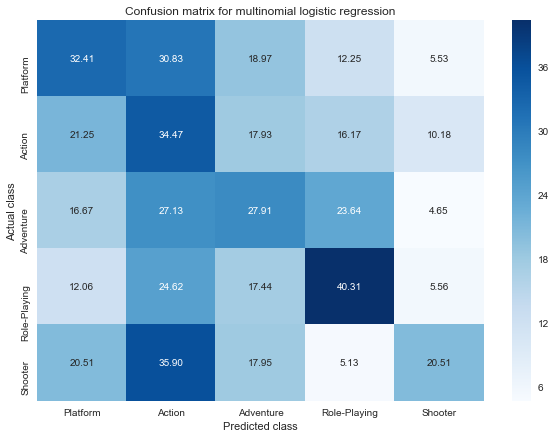

In [13]:
arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for multinomial logistic regression")
plt.show();

This confusion matrix is shown in terms of percentage of classification per class. An example of how to read it is the following:

platforms games have been correctly classified in 32.41% of the cases, while in the 30.83% of the cases they have been misclassified as action.

This matrix shows that most of the confusion is mostly due to the Action class, which is also the most represented one. In fact, it can be noted that the model has a general tendency to output Action at the predicted label.

The genre that is the best classified is the "Role-Playing". An explanation for this behaviour could be that Role-Playing has the most distinguishable music style. Indeed, many Role-Playing games have a medieval-fantasy setting, thus its music often borrows lots of musical features of epic register akin to some of the works of Debussy and Wagner.

Since the class are not perfecly balanced, a logistic regression that gives different weights to each genre was tested. The weighted are inversely proportional to the genre frequency. 

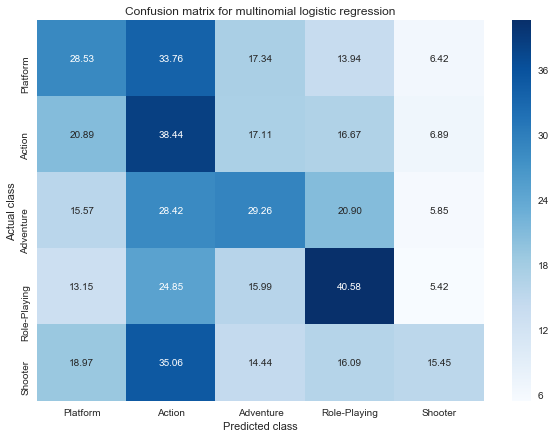

The Logistic Regression classifier predicts correclty of 30.267% of the training test and of 29.489% of the testing set


In [23]:
clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2", class_weight='balanced')
clf.fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for multinomial logistic regression")
plt.show();
print("The Logistic Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

The results are even worse and the confusion matrix looks very similar as previously. This could indicate that some features really push towards a particular genre.

Since this linear model performs poorly for the given task, it may be the case that the data is not linearly separable, thus an ensemble model was tested.

Since random forest parameters can be tricky to choose and make greatly variate the results, a simple grid-search was performed.

The best accuracy was 34.39% with parameters {'n_estimator': 26.5, 'max_depth': 2.0, 'max_feature': 'log2'}


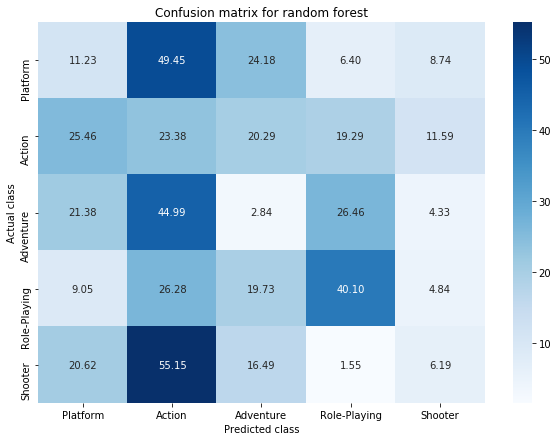

In [164]:
n_estimators = np.linspace(2, 100, 5)
max_depths = np.linspace(2, 50, 5)
max_features = ['sqrt', 'log2']
best_score = 0.0
best_params = []
for n_estimator in n_estimators:
    for max_depth in max_depths:
        for max_feature in max_features:
            params = {'n_estimator': n_estimator, 'max_depth': max_depth, 'max_feature': max_feature}
            clf = RandomForestClassifier(n_estimators=int(n_estimator), max_depth=int(max_depth), max_features=max_feature, random_state=1)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            if score > best_score:
                best_score = score
                best_params = params
                
print("The best accuracy was %.2f%% with parameters %s"%(best_score*100, best_params))
rfc = RandomForestClassifier(\
                             n_estimators=int(best_params['n_estimator']),\
                             max_depth=int(best_params['max_depth'],\
                             max_features=best_params['max_feature'])
rfc.fit(X_train, y_train)
arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for random forest")
plt.show();

The accuracy of the classification did not improve even by using this model that should be able to fit not linearly separable data. The confusion matrix is similar to the one previously shown, showing even worse results.

A kernel method was also tested to see if mapping data in a more complex space would help.

In [21]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 
score = clf.score(X_test, y_test)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print("The Kernelized Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

The Kernelized Regression classifier predicts correclty of 47.121% of the training test and of 34.080% of the testing set


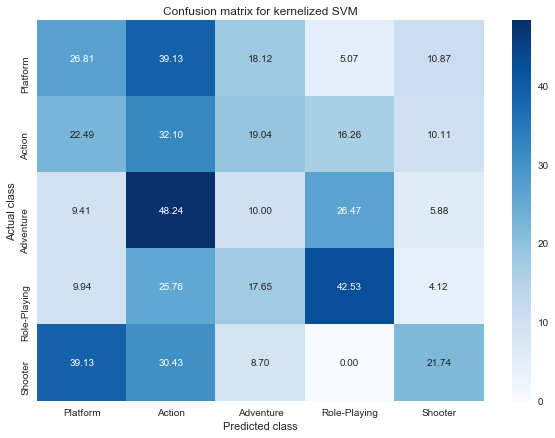

In [23]:
arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])

plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for kernelized SVM")
plt.show();

Once again, the results are very similar to those obtained witht the previous methods, both in term of accuracy and in term of confusion matrix.

Finally, the option thats some latent features could be used for the classification was explored using Principal component analysis.

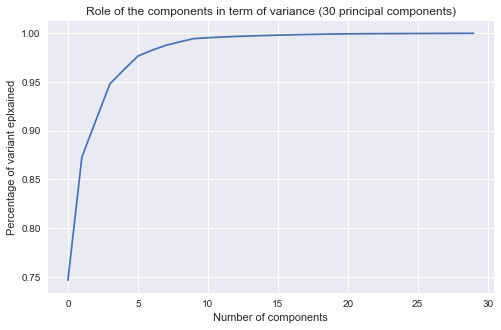

In [40]:
pca = PCA(n_components=X_train_orig.shape[1])
pca.fit(X_train_orig)
plt.figure(figsize=(8,5))
plt.plot(pca.explained_variance_ratio_.cumsum()[:30])
plt.xlabel('Number of components')
plt.ylabel('Percentage of variant eplxained')
plt.title("Role of the components in term of variance (30 principal components)");

In [47]:
print("\n".join(\
                ["%d components explain %.2f%% of the variance"%(idx+1, ratio*100)\
                 for idx, ratio in enumerate(pca.explained_variance_ratio_.cumsum()[:10])]))

1 components explain 74.64% of the variance
2 components explain 87.28% of the variance
3 components explain 91.04% of the variance
4 components explain 94.78% of the variance
5 components explain 96.23% of the variance
6 components explain 97.63% of the variance
7 components explain 98.22% of the variance
8 components explain 98.73% of the variance
9 components explain 99.09% of the variance
10 components explain 99.42% of the variance


As we can see, with only 1 components, we already explain more than 74% of the variance (!)

With 9 components, we explain more than 99% of the variance.

Let's vizualise the data in 2 dimension.

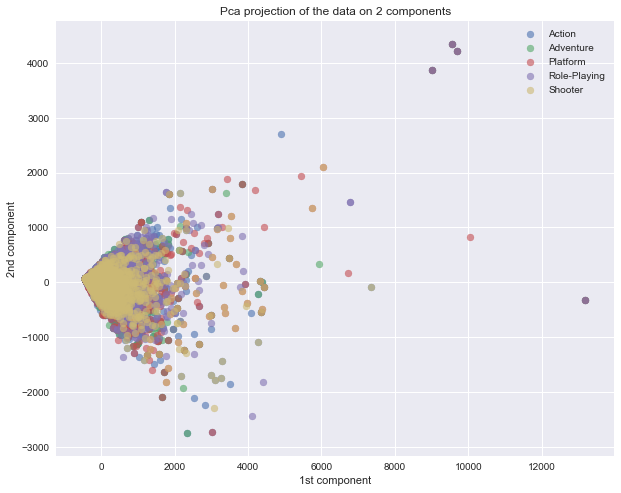

In [42]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
for genre, group in df_pred_sel.groupby('genre'):
    x = pca.transform(group.iloc[:,2:])
    plt.scatter(x[:,0], x[:,1] ,
            label=genre, alpha=0.6)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title("Pca projection of the data on 2 components")
plt.legend();

At first sight, it seems that even the two dimension do not allow to easily separate the data, even though they capture most of the data.

As a final resort, the classification task is performed through logistic regression but only by considering the 9 Principal Component Analysis.

In [43]:
pca_scaler = StandardScaler()
X_train_9d = pca_scaler.fit_transform(pca.transform(X_train_orig)[:,:9])
X_test_9d = pca_scaler.transform(pca.transform(X_test_orig)[:,:9])

In [45]:
clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train_9d, y_train)

train_score = clf.score(X_train_9d, y_train)
test_score = clf.score(X_test_9d, y_test)

print("The Logistic Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

clf = SVC(kernel='rbf')
clf.fit(X_train_9d, y_train) 

train_score = clf.score(X_train_9d, y_train)
test_score = clf.score(X_test_9d, y_test)

print("The Kernelized Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

The Logistic Regression classifier predicts correclty of 33.108% of the training test and of 32.636% of the testing set
The Kernelized Regression classifier predicts correclty of 35.339% of the training test and of 33.543% of the testing set


As it can be seen even though the 9 first principal components capture more than 99% of the variance of the data, they do not allow to make a clear distinction between the different genres.